Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [1]:
%matplotlib inline
import numpy as np
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
from numba import jit

from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from calovi import WallModel, SocialModel

np.set_printoptions(suppress=True)

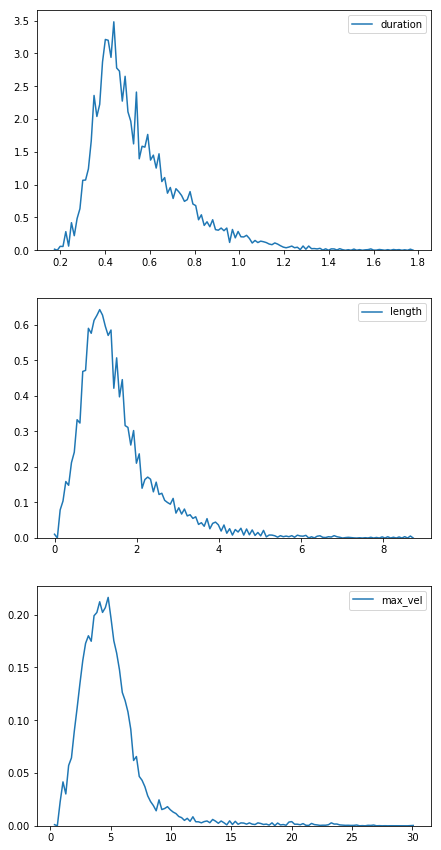

In [2]:
df = pd.read_csv("../../data/processed/kicks_guy.csv")
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'], bw=.002, ax=ax[0])
sns.kdeplot(df['length'],bw=.002, ax=ax[1])
sns.kdeplot(df['max_vel'], bw=.002, ax=ax[2])

def fit_mixture(df, column, n_components=2):
    var = df[column].values.reshape(-1, 1)
    mix = GaussianMixture(n_components=n_components)
    mix.fit(var)
    return mix

# Create models for duration, length, max_velocity that we can sample from
duration_gmm = fit_mixture(df, 'duration')
length_gmm = fit_mixture(df, 'length')
max_vel_gmm = fit_mixture(df, 'max_vel')

with open('../duration.model', 'wb') as f:
    pickle.dump(duration_gmm, f)
    
with open('../length.model', 'wb') as f:
    pickle.dump(length_gmm, f)
    
with open('../max_velocity.model', 'wb') as f:
    pickle.dump(max_vel_gmm, f)

In [3]:
# Quick hack to find velocity decay parameter!
x0 = np.array([1.0])
max_vel = df['max_vel'].values
end_vel = df['end_vel'].values
duration = df['duration'].values
vel_ratio = end_vel/max_vel
decay = lambda time, decay: np.exp(- decay * time)
res = curve_fit(decay, xdata=duration, ydata=vel_ratio, p0=x0)
res[0]

array([ 0.83783442])

In [4]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,gliding_duration,length,max_vel,end_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,...,wall_angle2_f0,wall_angle3_f0,wall_distance0_f1,wall_distance1_f1,wall_distance2_f1,wall_distance3_f1,wall_angle0_f1,wall_angle1_f1,wall_angle2_f1,wall_angle3_f1
count,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,...,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000,6783.000000
mean,0.008096,0.538774,0.263551,1.522307,5.437300,4.556818,2.479475,-0.060220,-0.265290,0.047525,...,0.109302,-1.454547,14.678219,15.783035,15.142560,13.677261,0.079121,1.611013,0.084216,-1.462033
std,1.095196,0.187204,0.109569,0.903750,3.177733,2.667299,1.878952,1.800921,2.090332,1.392632,...,2.415906,0.964109,9.522416,9.448482,9.522416,9.448482,0.907467,0.967326,2.418675,0.947876
min,-3.131853,0.180106,0.030018,0.000953,0.414433,0.230809,0.398733,-3.140936,-3.141578,-3.113466,...,-3.140573,-3.139016,0.422879,0.075460,0.331086,0.128763,-2.262596,-3.136529,-3.141572,-3.140601
25%,-0.352471,0.410242,0.200118,0.926029,3.650363,2.971403,1.773752,-1.584675,-2.217315,-1.034375,...,-2.183634,-2.159097,4.917054,6.652564,5.736420,4.201400,-0.613428,0.941210,-2.198099,-2.166888
50%,0.037530,0.480283,0.250148,1.339644,4.907932,4.252564,2.233717,-0.178929,-0.923396,0.141046,...,1.484626,-1.568025,14.847819,16.399698,14.972959,13.060599,-0.002380,1.556360,1.246539,-1.562998
75%,0.408404,0.640378,0.300177,1.873038,6.272373,5.515776,2.782224,1.567512,1.844863,1.061816,...,2.549787,-0.610231,24.084358,25.258897,24.903725,22.807732,0.939912,2.492213,2.531088,-0.614169
max,3.138190,1.711010,1.100649,7.713041,30.056470,30.056470,30.505288,3.141502,3.140943,3.135925,...,3.141189,3.141418,29.489692,29.331533,29.397899,29.384836,2.049724,3.139827,3.141498,3.140249


In [5]:
# Try grad.desc as a sanity check
def calc_wall_error(model, xdata, ydata, params=None):
    lambda_reg = 0.0
    return np.linalg.norm (model(xdata) - ydata)

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

def compute_r2(x, y, model=None, yhat=None):
    if yhat is None:
        yhat = model(x)
    residuals = y - yhat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [6]:
heading_change = df['heading_change'].values
wall_distance0 = np.vstack([df[f'wall_distance{i}_f0'].values for i in range(4)])
wall_angle0 = np.vstack([-df[f'wall_angle{i}_f0'].values for i in range(4)])

xdata_wall = np.vstack((wall_distance0, wall_angle0))
ydata = heading_change

# Model
angular_model = 'sin-cos'
wall_model = WallModel(angular_model)
angular = WallModel.angular_map
init_x = WallModel.params_map

eval_wall_model = lambda xdata, *params: wall_model.evaluate_raw(xdata, *params)
x0 = init_x[angular_model]

l_bounds = np.array([-np.inf] * len(x0))
u_bounds = np.array([ np.inf] * len(x0))
l_bounds[0] = 0.0 # no negative decay
bounds = (l_bounds, u_bounds)

res = curve_fit(eval_wall_model, xdata=xdata_wall, ydata=ydata, p0=x0, bounds=bounds,max_nfev=1000000)
x_opt_wall = res[0]

fitted_model = lambda xdata: eval_wall_model(xdata, *x_opt_wall)
random_model = lambda xdata: eval_wall_model(xdata, *x0)
mean_model = lambda xdata: np.ones_like(xdata) * np.mean(ydata)

print(f"Curve fit reached error of {calc_wall_error(fitted_model, xdata_wall, ydata, x_opt_wall)} with params={str(x_opt_wall)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {calc_wall_error(random_model, xdata_wall, ydata, x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading_error = calc_wall_error(mean_model, xdata_wall, ydata, np.array([0.0]))
print(f"Predicting the average heading {np.mean(ydata)} for each heading leads to an error of {mean_heading_error}")

print(f"Model has r^2 of {compute_r2(xdata_wall, ydata, fitted_model)}")
yHat = fitted_model(xdata_wall)
print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
print(f"{spearmanr(ydata, -fitted_model(xdata_wall))}")

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_wall.model', 'wb') as file:
    pickle.dump(wall_model, file)

Curve fit reached error of 84.19630083482299 with params=[  4.96179205  19.26674405  -0.004644     5.17408047   0.00002627
   0.01315064]
1-Std-error of params is [ 286250.9942061        0.03276904     267.91740316  298498.13709906
       0.00141669       0.0009422 ]
Random params reached error of 142.56577914797305 with params=[ 6.  1.  1.  1.  1.  1.]
Predicting the average heading 0.008096013783384301 for each heading leads to an error of 255.10311114181872
Model has r^2 of 0.12854593693275684
Correlation=0.35940418809379515
SpearmanrResult(correlation=-0.29283895662260029, pvalue=3.1786983146763202e-134)


    def loss_wall(params):
        lambda_reg = 10e-3
        yHat = model_wall(xdata_wall, *params)
        return np.mean(np.square(ydata - yHat)) + np.linalg.norm(params)

    res = minimize(loss_wall, x0)
    fitted_model = lambda xdata: model_wall(xdata, *res.x)
    print(f"Model has r^2 of {compute_r2(fitted_model, xdata_wall, ydata)}")
    yHat = fitted_model(xdata_wall)
    print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
    print(res.x)

4.96179205398 13.386143092497294
Multiplier is 66.41925842985492


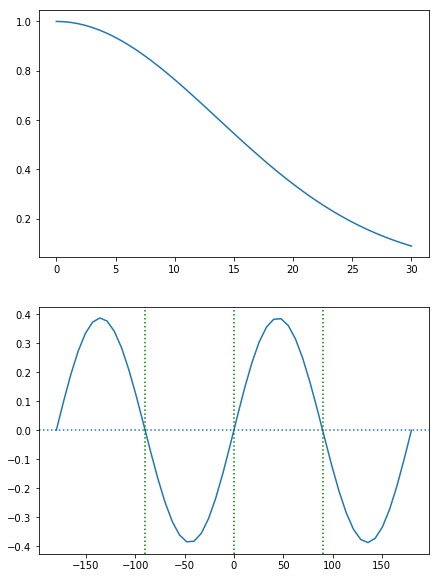

In [7]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(model):
    fCur = lambda dist: wall_model.wall_force(dist)
    OCur = lambda angle: wall_model.wall_repulsion(angle)
    norm_const = get_norm_const(OCur, np.linspace(-np.pi, np.pi))
    print(wall_model.scale, norm_const)
    print(f"Multiplier is {norm_const * wall_model.scale}")
    
    fig, ax = plt.subplots(2, 1, figsize=(7,10) )
    
    ax[0].plot(np.linspace(0, 30), fCur(np.linspace(0,30)))
    ax[1].plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))/norm_const)
    plt.axhline(0, linestyle='dotted')
    ax[1].axvline(90, linestyle='dotted', c='g')
    ax[1].axvline(0.0, linestyle='dotted', c='g')
    ax[1].axvline(-90, linestyle='dotted', c='g')
plotFit(wall_model)

In [8]:
df.columns

Index(['fish_id', 'heading_change', 'duration', 'gliding_duration', 'length',
       'max_vel', 'end_vel', 'neighbor_distance', 'neighbor_angle',
       'geometric_leader', 'viewing_angle_ltf', 'viewing_angle_ftl',
       'rel_orientation', 'wall_distance0_f0', 'wall_distance1_f0',
       'wall_distance2_f0', 'wall_distance3_f0', 'wall_angle0_f0',
       'wall_angle1_f0', 'wall_angle2_f0', 'wall_angle3_f0',
       'wall_distance0_f1', 'wall_distance1_f1', 'wall_distance2_f1',
       'wall_distance3_f1', 'wall_angle0_f1', 'wall_angle1_f1',
       'wall_angle2_f1', 'wall_angle3_f1'],
      dtype='object')

In [9]:
def toMin(model, x_opt_social):
    yHat = model(xdata_social, *x_opt_social)
    return np.linalg.norm(yHat - ydata)

# TODO: Drop if one wall distance is smaller than 2ish
dff = df
for i in range(4):
    continue
    dff = dff.drop(dff[dff[f'wall_distance{i}_f0'] < 2].index)
# Data
heading_change = dff['heading_change'].values
neighbor_distance = dff['neighbor_distance']
viewing_angle = np.zeros(dff['viewing_angle_ftl'].shape)

# Angles between fish are saved w.r.t. geometric leader
fish_is_leader = dff['fish_id'] == dff['geometric_leader']
viewing_angle[fish_is_leader] = dff['viewing_angle_ltf'][fish_is_leader]
viewing_angle[~fish_is_leader] = dff['viewing_angle_ftl'][~fish_is_leader]
relative_angle = np.zeros(dff['rel_orientation'].shape)
relative_angle[fish_is_leader] = dff['rel_orientation'][fish_is_leader]
relative_angle[~fish_is_leader] = -dff['rel_orientation'][~fish_is_leader]

# Get correct xdata for wall estimation!
wall_distance0 = np.vstack([dff[f'wall_distance{i}_f0'].values for i in range(4)])
wall_angle0 = np.vstack([-dff[f'wall_angle{i}_f0'].values for i in range(4)])
xdata_wall = np.vstack((wall_distance0, wall_angle0))

xdata_social = np.vstack((neighbor_distance, viewing_angle, relative_angle))
ydata = heading_change

#if reflect:    
#xdata_social_reflected = np.vstack((neighbor_distance, -viewing_angle, -relative_angle))
#xdata_social = np.hstack((xdata_social, xdata_social_reflected))
 
print(xdata_social.shape, ydata.shape)

def even_fun(angle, *weights):
    result = 1.0
    for i, weight in enumerate(weights):
        result += weight * np.cos((i+1) * angle)
    return result

def odd_fun(angle, *weights):
    result = 0.0
    for i, weight in enumerate(weights):
        result += weight * np.sin((i+1) * angle)
    return result

f_att = lambda dist, p1, p2, s: s * (dist - p1)/(1 + (dist/p2)**2)
o_att = odd_fun #lambda angle, p1: np.sin(angle) * (1 + p1 * np.cos(angle))
e_att = even_fun #lambda angle, p1, p2: 1 + p1 * np.cos(angle) + p2 * np.cos(2*angle)

f_ali = lambda dist, p1, p2, s: s * (dist + p1) * np.exp(-(dist/p2)**2) 
o_ali = odd_fun #lambda angle, p1: np.sin(angle) * (1 + p1 * np.cos(2*angle))
e_ali = even_fun #lambda angle, p1, p2: 1 + p1 * np.cos(angle) + p2 * np.cos(2*angle)                                           

def model_social(xdata, *params):
    assert(False)
    params = np.array(params)
    f_att_cur = lambda dist:  f_att(dist, params[0], params[1], params[2])
    f_ali_cur = lambda dist: f_ali(dist, params[3], params[4], params[5])
    
    def get_params_slice(num_fun):
        offset = 5 + num_fun * num_params
        return params[offset:offset+num_params]
        
    o_att_cur = lambda a: odd_fun(a, *get_params_slice(0))
    e_att_cur = lambda a: even_fun(a, *get_params_slice(1))
    o_ali_cur = lambda a: odd_fun(a, *get_params_slice(2))
    e_ali_cur = lambda a: even_fun(a, *get_params_slice(3))
    
    attraction = f_att_cur(xdata[0]) * o_att_cur(xdata[1]) * e_att_cur(xdata[2])
    alignment = f_ali_cur(xdata[0]) * o_ali_cur(xdata[2]) * e_ali_cur(xdata[1])
    return 0.0
    return attraction + alignment

num_params = 2
#x0 = np.hstack((np.array([0.3, 2.0,1.0]), np.array([1.0] * 3), np.zeros(num_params * 4)+1))

social_model = SocialModel()
x0 = social_model.params
eval_social_model = lambda xdata, *params: social_model.evaluate_raw(xdata, *params)
#eval_social_model = model_social

res = curve_fit(eval_social_model, xdata=xdata_social, ydata=ydata - eval_wall_model(xdata_wall, *x_opt_wall), p0=x0)
x_opt_social = res[0]

fitted_model = lambda xdata: eval_social_model(xdata, *x_opt_social)
random_model = lambda xdata: eval_social_model(xdata, *x0)

print(f"Curve fit reached error of {toMin(eval_social_model, x_opt_social)} with params={str(x_opt_social)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {toMin(eval_social_model, x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading = np.mean(ydata)
mean_heading_error = np.sum( (ydata - mean_heading)**2 )
print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

print(f"Model has r^2 of {compute_r2(xdata_social, ydata, fitted_model)}")
yHat = fitted_model(xdata_social)
print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

yHat_full = eval_social_model(xdata_social, *x_opt_social) + eval_wall_model(xdata_wall, *x_opt_wall)
print(f"Full model correlation={np.corrcoef(ydata, yHat_full)[0,1]}")
print(f"Full Model has r^2 of {compute_r2(xdata_social, ydata, yhat=yHat_full)}")

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_social.model', 'wb') as file:
    pickle.dump(social_model, file)

(3, 6783) (6783,)
Curve fit reached error of 84.43699070374154 with params=[  1.09140022   0.70450348   0.08861996  77.85527684   7.42259361
   0.01488196   0.25949615  53.18637066 -61.69699759   0.55128809
  -0.1752437   -0.04276508   0.05965758   1.        ]
1-Std-error of params is [ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
Random params reached error of 189.68541064638083 with params=[ 0.3  2.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1. ]
Predicting the average heading 0.008096013783384301 for each heading leads to an error of 8134.699664279389
Model has r^2 of 0.12355640732369821
Correlation=0.3707640507499359
Full model correlation=0.44337785903138655
Full Model has r^2 of 0.19280703419972423


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


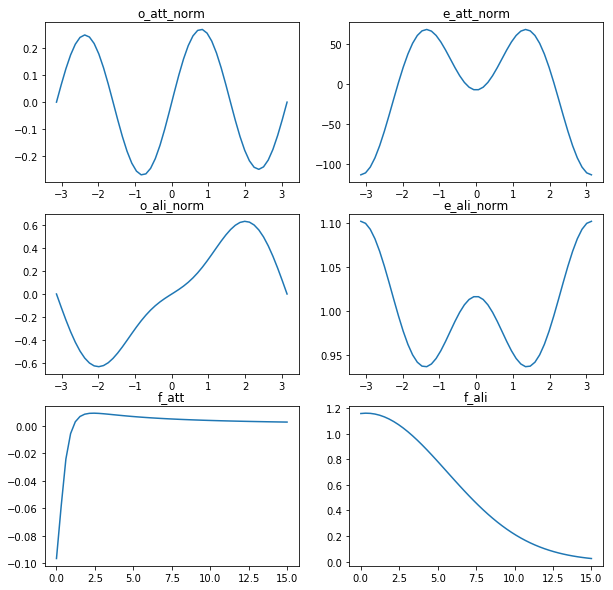

In [10]:
def get_norm_const(function, parameters):
    '''Normalizing factor s.t. square integral over -pi/pi is 1'''
    return 1/(2*np.pi) * quad(lambda a: function(a, *parameters)**2, -np.pi, np.pi)[0]

def eval_norm_func(function, parameters, angles):
    '''Evaluate a normalized angular function.
    Useful for plotting'''
    norm_const = get_norm_const(function, parameters)
    norm_const = 1.0
    return function(angles, *parameters) / norm_const

def get_params_slice(num_fun):
    '''Helper function for social model.
    TODO: Refactor this stuff out.'''
    params = x_opt_social
    offset = 5 + num_fun * num_params
    return params[offset:offset+num_params]

fig, ax = plt.subplots(3,2, figsize=(10,10))
x = np.linspace(-np.pi, np.pi)
norm_factor = get_norm_const(o_att, get_params_slice(0)) * get_norm_const(e_att, get_params_slice(1))
ax[0][0].plot(x, eval_norm_func(o_att, get_params_slice(0), x), label='o_att_norm')
ax[0][0].set_title("o_att_norm")
ax[0][1].plot(x, eval_norm_func(e_att, get_params_slice(1), x), label='e_att_norm')
ax[0][1].set_title("e_att_norm")

ax[1][0].plot(x, eval_norm_func(o_ali, get_params_slice(2), x), label='o_ali_norm')
ax[1][0].set_title("o_ali_norm")
ax[1][1].plot(x, eval_norm_func(e_ali, get_params_slice(3), x), label='e_ali_norm')
ax[1][1].set_title("e_ali_norm")

x = np.linspace(0, 15)
ax[2][0].plot(x, f_att(x, *x_opt_social[0:3]), label='f_att')
ax[2][0].set_title("f_att")
ax[2][1].plot(x, f_ali(x, *x_opt_social[3:6]), label='f_ali')
ax[2][1].set_title("f_ali")